# **Lab1: Programming Assignment: Sequence Alignment Using Edit Distance Algorithms**


Samantha Sánchez Tinoco

Daniela de la Torre Gallo

Clara Paola Aguilar Casillas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.Align import PairwiseAligner
import csv
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Tuple
import gzip
import os
import math

c:\Users\Daniela de la Torre\anaconda3\envs\iteso\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## Notas
- Usamos scoring por defecto: **match = +2**, **mismatch = -1**, **gap = -2**.
- Los algoritmos implementados usan penalidad lineal por gaps.
- Para hacer la comparación con secuencias reales utilizamos la alternativa de Bio `SeqIO.parse`.


In [2]:
# Devuelve la reverse-complement de una secuencia de ADN
def reverse_complement(seq: str) -> str:
    return str(Seq(seq).reverse_complement())

# Calcula la puntuación (score) del alineamiento ya construido.
def score_from_alignment(a1: str, a2: str, match=2, mismatch=-1, gap=-2) -> int:
    s = 0 # acumulador
    for x, y in zip(a1, a2):
        if x == '-' or y == '-':
             # Penalización por gap
            s += gap
        elif x == y:
            # Match
            s += match
        else:
            # Mismatch
            s += mismatch
    return s

### Algoritmo Needleman-Wunsch

Implementación from-scratch

In [3]:
def needleman_wunsch(seq1: str, seq2: str, match=2, mismatch=-1, gap=-2) -> Tuple[np.ndarray, str, str, List[Tuple[int,int]]]:
    # seq1, seq2: cadenas a alinear
    # match, mismatch, gap: parámetros de scoring
    n, m = len(seq1), len(seq2)
    # Matriz de scores (n+1 x m+1)
    score_matrix = np.zeros((n+1, m+1), dtype=int)

    # Inicialización: alinear prefijos con vacío -> penalización por gaps
    for i in range(1, n+1):
        score_matrix[i, 0] = i * gap
    for j in range(1, m+1):
        score_matrix[0, j] = j * gap

    # Relleno de la matriz (programación dinámica)
    for i in range(1, n+1):
        for j in range(1, m+1):
            # Opción diagonal: match/mistmatch
            diag = score_matrix[i-1, j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch)
            # Opción arriba: gap en seq2
            up = score_matrix[i-1, j] + gap  
            # Opción izquierda: gap en seq1   
            left = score_matrix[i, j-1] + gap  
            # Elegir la mejor opción
            score_matrix[i, j] = max(diag, up, left)

    # Traceback para reconstruir alineamiento + path
    align1, align2 = "", ""
    path = []
    i, j = n, m
    while i > 0 and j > 0:
        path.append((i, j))
        current = score_matrix[i, j]
        if current == score_matrix[i-1, j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch):
            align1 = seq1[i-1] + align1
            align2 = seq2[j-1] + align2
            i -= 1
            j -= 1
        elif current == score_matrix[i-1, j] + gap:
            align1 = seq1[i-1] + align1
            align2 = "-" + align2
            i -= 1
        else:
            align1 = "-" + align1
            align2 = seq2[j-1] + align2
            j -= 1

    # Si quedan prefijos, añadir gaps correspondientes y path
    while i > 0:
        path.append((i, 0))
        align1 = seq1[i-1] + align1
        align2 = "-" + align2
        i -= 1
    while j > 0:
        path.append((0, j))
        align1 = "-" + align1
        align2 = seq2[j-1] + align2
        j -= 1

    # Añadir el inicio (0,0) al path y revertirlo
    path.append((0,0))
    path.reverse() 
    return score_matrix, align1, align2, path


### Algoritmo Smith-Waterman

In [4]:
def smith_waterman(seq1: str, seq2: str, match=2, mismatch=-1, gap=-2) -> Tuple[np.ndarray, str, str, List[Tuple[int,int]]]:
    # Inicialización
    n, m = len(seq1), len(seq2)
    score_matrix = np.zeros((n+1, m+1), dtype=int)
    max_score = 0
    max_pos = (0,0)
    
    # Relleno sin permitir valores negativos
    for i in range(1, n+1):
        for j in range(1, m+1):
            diag = score_matrix[i-1, j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch)
            up = score_matrix[i-1, j] + gap
            left = score_matrix[i, j-1] + gap
            val = max(0, diag, up, left)
            score_matrix[i,j] = val
            # Actualizar mejor posición
            if val > max_score:
                max_score = val
                max_pos = (i,j)
                
    # Traceback desde max_pos hasta que se llega a 0
    align1, align2 = "", ""
    path = []
    i, j = max_pos
    while i > 0 and j > 0 and score_matrix[i,j] != 0:
        path.append((i,j))
        current = score_matrix[i,j]
        if current == score_matrix[i-1,j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch):
            align1 = seq1[i-1] + align1
            align2 = seq2[j-1] + align2
            i -= 1
            j -= 1
        elif current == score_matrix[i-1,j] + gap:
            align1 = seq1[i-1] + align1
            align2 = "-" + align2
            i -= 1
        else:
            align1 = "-" + align1
            align2 = seq2[j-1] + align2
            j -= 1

    # Añadir el inicio (0,0) al path y revertirlo
    path.reverse()
    return score_matrix, align1, align2, path


## Visualización
A continuación hay funciones para dibujar la matriz de scores (heatmap) y superponer el path del traceback para entender cómo se construyó el alineamiento.

In [5]:
def plot_score_matrix(score_matrix: np.ndarray, path: List[Tuple[int,int]] = None, title: str = "Score matrix"):
    # Score matrix heatmap
    plt.figure(figsize=(8,6))
    # Dibujar heatmap
    sns.heatmap(score_matrix, annot=False, cmap="viridis")
    plt.title(title)
    plt.xlabel("j (seq2 index)")
    plt.ylabel("i (seq1 index)")
    
    # Si tenemos path, dibujarlo encima
    if path:
        # Convertir path a coordenadas de heatmap para trazarlo
        ys = [p[0] + 0.5 for p in path] 
        xs = [p[1] + 0.5 for p in path]
        plt.plot(xs, ys, color="red", marker="o")
    plt.show()

## Secuencias de prueba

Uso de los 10 pares de secuencias proporcionados en el PDF del laboratorio

In [6]:
queries = [
"GACTTACGCGCCGTAGCACTTCTGTGATAGCTGCGAGGCGTATTGCTACTTGTACGAGATAGGGTCGACTTTTCGGAGTCGACAGACACTACGATACT",
"GTAGTCATTACCCATAGGCGTTTGCTGACTATCGGGAGAGGTACGTACGTGATACGACTGTCGATCGCTCGTAGATCAAGATACTCAGCGTGCTGTC",
"CTGCATACCGACAAACGTGTGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCACATGCATACGTGCGTGTCTACGTACGT",
"GGATGCGACTAGGAGTCGAGTGTCGATTCTATAGCGATAGCGAGTAGCGACTAGTCACTGTACTGTAGCATAGCGATACGAGCATAGCATAGCA",
"TCGATCGTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGC",
"ATGCGTATACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACG",
"TTAAATTATATATATACGCGCGCGCGACACACACACACTGATCTATACGCGCGCGCGCGATAGCGATAGCGATCGATCGCGCTATATATATA",
"CTACTGAGTCGTAGCTAGCGAGTCGAGTGCGTGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGC",
"GCATGCGACTTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCATGC",
"CGCGATAGCGATAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAG"
]

# Crear los pares (las reversas que vienen en el PDF)
rc_map = {q: reverse_complement(q) for q in queries}


### Pruebas con los modelos from scratch

In [7]:
# Ejecutar algoritmos from-scratch y su complemento en reversa
results_manual = []
for q in queries:
    seq = q
    rc = rc_map[q]
    # Needleman-Wunsch
    M_nw, a1_nw, a2_nw, path_nw = needleman_wunsch(seq, rc, match=2, mismatch=-1, gap=-2)
    score_nw = M_nw[-1,-1]
    # Smith-Waterman
    M_sw, a1_sw, a2_sw, path_sw = smith_waterman(seq, rc, match=2, mismatch=-1, gap=-2)
    # Calcular score desde alineamientos 
    calc_nw = score_from_alignment(a1_nw, a2_nw, match=2, mismatch=-1, gap=-2)
    calc_sw = score_from_alignment(a1_sw, a2_sw, match=2, mismatch=-1, gap=-2)

    results_manual.append({
        "query": seq,
        "rc": rc,
        "nw_score_matrix": M_nw,
        "nw_alignment": (a1_nw, a2_nw),
        "nw_score": score_nw,
        "nw_score_check": calc_nw,
        "nw_path": path_nw,
        "sw_score_matrix": M_sw,
        "sw_alignment": (a1_sw, a2_sw),
        "sw_score": M_sw.max(),  # score máximo en matriz
        "sw_score_check": calc_sw,
        "sw_path": path_sw
    })

# Resultados de cada secuencia
for r in results_manual:
    print("Query len:", len(r["query"]), 
          "NW score:", r["nw_score"], 
          "SW score:", r["sw_score"])



Query len: 98 NW score: 52 SW score: 56
Query len: 97 NW score: 56 SW score: 63
Query len: 94 NW score: 116 SW score: 120
Query len: 94 NW score: 62 SW score: 68
Query len: 95 NW score: 166 SW score: 172
Query len: 95 NW score: 160 SW score: 172
Query len: 92 NW score: 64 SW score: 88
Query len: 90 NW score: 84 SW score: 118
Query len: 90 NW score: 162 SW score: 162
Query len: 90 NW score: 150 SW score: 156


### Visualizar matriz y path para los pares

Query (trunc): GACTTACGCGCCGTAGCACTTCTGTGATAGCTGCGAGGCGTATTGCTACTTGTACGAGATAGGGTCGACTTTTCGGAGTC ...
NW alignment:
-G-A-CTTACGCG-CCGTAGCACTTCTGTGATAGCTGCGAGGCGTAT-TGCTACTTGTACGAGATA-GGGTCG-A-CT-TTTC-GGAGT-CGACAGACAC-TACGATACT
AGTATCGTA-GTGTCTGTCG-AC-TCCG-AAAAG-T-CGA-CCCTATCTCGTACAAGTA-GCAATACGCCTCGCAGCTATCACAGAAGTGCTAC-GGCGCGTAAG-T-C-


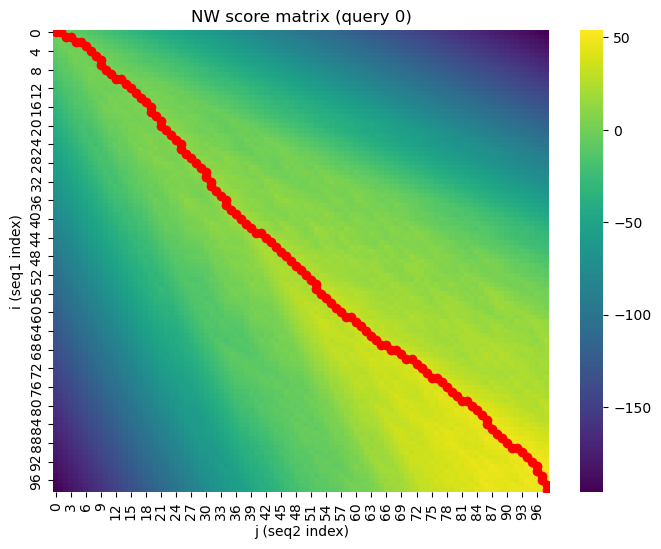


SW alignment (mejor subsegmento):
CTTACGCG-CCGTAGCACTTCTGTGATAGCTGCGAGGCGTAT-TGCTACTTGTACGAGATA-GGGTCG-A-CT-TTTC-GGAGT-CGACAGACAC-TACG
CGTA-GTGTCTGTCG-AC-TCCG-AAAAG-T-CGA-CCCTATCTCGTACAAGTA-GCAATACGCCTCGCAGCTATCACAGAAGTGCTAC-GGCGCGTAAG


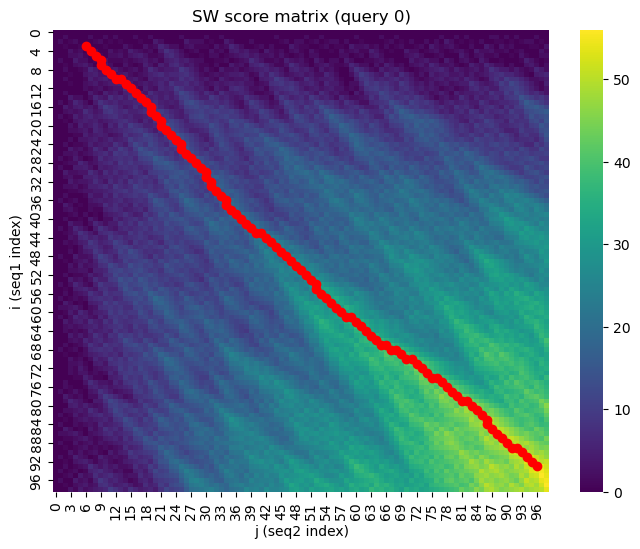

In [8]:
idx = 0  # cambiar para ver el de otra secuencia
res = results_manual[idx]

# Mostrar alineamientos 
print("Query (trunc):", res["query"][:80], "...")
print("NW alignment:")
print(res["nw_alignment"][0])
print(res["nw_alignment"][1])
plot_score_matrix(res["nw_score_matrix"], res["nw_path"], title=f"NW score matrix (query {idx})")

print("\nSW alignment (mejor subsegmento):")
print(res["sw_alignment"][0])
print(res["sw_alignment"][1])
plot_score_matrix(res["sw_score_matrix"], res["sw_path"], title=f"SW score matrix (query {idx})")


Lo que se puede observar en el caso de **Smith-Waterman (Local Alignment)**

Aquí la matriz representa el alineamiento local, buscando el subsegmento más parecido entre ambas secuencias.

En este caso, los valores nunca bajan de 0 (propio del algoritmo).

Lo que se puede observar en el heatmap:

La parte superior izquierda es morada (0), porque ahí no hay similitud.

Los valores altos (amarillos) aparecen en una región más concentrada, mostrando el segmento donde las dos secuencias son muy parecidas.

No importa si las secuencias completas no coinciden, Smith-Waterman resalta solo el mejor fragmento.

Para resumir lo que hace Smith-Waterman es que se enfoca en encontrar las regiones locales más similares, en lugar de forzar un alineamiento global.

### Diferencias entre ambos

Needleman-Wunsch: busca la mejor coincidencia considerando toda la longitud → útil si las secuencias son similares en su totalidad.

Smith-Waterman: busca el mejor fragmento coincidente → útil cuando hay regiones de alta similitud dentro de secuencias más largas o diferentes.

### Parámetros

A continuación, demostramos la diferencias que se llevan a cabo cuando se aplican alineamientos de secuencias modificando los parámetros de match, mismatch y gap. 
Los cambios realizados son aplicados en las penalizaciones y se mostrara como las recompensas influyen en que se encuentre la mejor coincidencia.

Se buscó ajustar las dos secuencias en toda su longitud. Como no era tan fuerte el castigo por huecos fue cuando utilizamos guiones para lograr coincidencias y maximizar el número de matches. Esto nos permite reflejar un equilibrio entre coincidencias y huecos, para así permitir alinear regiones a pesar de diferencias.

Al reducir las penalizaciones del gap, el alineamiento se centró en encontrar un fragmento con muchas coincidencias y extenderse con mayor facilidad, sin importar tanto el resto de la secuencia. Así se logró un bloque más largo de similitud. El resultado nos muestra que un esquema de scoring más flexible que nos ayuda en alineamientos parciales más amplios.

Lo que se realizó fue priorizar el valor de las coincidencias exactas, y se castigaron mayormente los errores y gaps. El alineamiento global resulta más estricto y con menos tolerancia a diferencias, esto nos ayuda a que el alineamiento sea con mayor selectividad y mostrandonos partes que son iguales ya que son las únicas que se consideran valiosas sacrificando de esta forma coincidencias aproximadas. 

### Búsqueda de las secuencias en unas reales

En el dataset con `Bio.SeqIO`

In [9]:
# Buscar queries en un dataset cargado alternativamente con Bio.SeqIO
def search_in_dataset(seqio_path: str, queries: List[str], search_revcomp: bool = True, batch_records: int = 200) -> List[Dict]:
    seqio_path = Path(seqio_path)
    
    results = []
    processed = 0
    
    # Abrir archivo
    if str(seqio_path).lower().endswith(".gz"):
        handle = gzip.open(seqio_path, "rt")
    else:
        handle = open(seqio_path, "r")

   # Procesar secuencias una por una
    for rec in SeqIO.parse(handle, "fasta"):
        processed += 1
        seq_str = str(rec.seq).upper()
        rec_id = rec.id
        for q in queries:
            # Buscar directamente
            start = seq_str.find(q)
            if start != -1:
                results.append({"query": q, "type": "direct", "record_id": rec_id, "start": start, "end": start + len(q)})
            
            # Busqueda del complemento en reversa
            if search_revcomp:
                rc = reverse_complement(q)
                start2 = seq_str.find(rc)
                if start2 != -1:
                    results.append({"query": q, "type": "revcomp", "record_id": rec_id, "start": start2, "end": start2 + len(rc)})
        
        # Mensaje :)
        if processed % batch_records == 0:
            print(f"Procesados {processed} registros... matches hasta ahora: {len(results)}")
    
    
    handle.close()
    print(f"[Finalizado. Registros procesados: {processed}, matches: {len(results)}")
    return results



### Prueba con Biopython SeqIO

In [ ]:
# Comparar con Biopython para 1 ejemplo
def biopython_pairwise(seq1, seq2, match=2, mismatch=-1, gap=-2, global_alignment=True):

    if global_alignment:

        return pairwise2.align.globalms(seq1, seq2, match, mismatch, gap, 0)
    else:
        return pairwise2.align.localms(seq1, seq2, match, mismatch, gap, 0)

bp_aligns = biopython_pairwise(queries[0], rc_map[queries[0]], match=2, mismatch=-1, gap=-2, global_alignment=True)
print("Biopython (top 1) score:", bp_aligns[0].score)
print(bp_aligns[0].seqA[:200])
print(bp_aligns[0].seqB[:200])


Biopython (top 1) score: 76.0
-GACTTACGCGCCGTAGCACT-TCTGT-GATAGCTGCG---AGGCG----TATTGCTACTTGTACGAG-----ATAGGGTCGACTTTTCGGAG---TCGACAGACA---CTACG------ATACT-
AG---TA----TCGTAG---TGTCTGTCGA---CTCCGAAAAGTCGACCCTAT-----CTCGTACAAGTAGCAATA----CGCC---TCGCAGCTATC-ACAGA-AGTGCTACGGCGCGTA-AGTC


### Sensibilidad de parámetros

In [13]:
import pandas as pd
# Hecho con una query
def param_sensitivity(seqA, seqB, match_vals=[2], mismatch_vals=[-1], gap_vals=[-2]):
    records = []
    for match in match_vals:
        for mismatch in mismatch_vals:
            for gap in gap_vals:
                M_nw, a1, a2, _ = needleman_wunsch(seqA, seqB, match=match, mismatch=mismatch, gap=gap)
                swM, sa1, sa2, _ = smith_waterman(seqA, seqB, match=match, mismatch=mismatch, gap=gap)
                records.append({"match":match, "mismatch":mismatch, "gap":gap,
                                "nw_score": int(M_nw[-1,-1]), "sw_score": int(swM.max())})
    return records

# Definición de parametros a variar
match_vals = [2, 3]
mismatch_vals = [-1, -2]
gap_vals = [-2, -3]

sens = param_sensitivity(queries[0], rc_map[queries[0]], match_vals, mismatch_vals, gap_vals)
# Imprimir resultados
df_sens = pd.DataFrame(sens)
print(df_sens)


   match  mismatch  gap  nw_score  sw_score
0      2        -1   -2        52        56
1      2        -1   -3        28        38
2      2        -2   -2        32        40
3      2        -2   -3         4        20
4      3        -1   -2       116       120
5      3        -1   -3        90        96
6      3        -2   -2        96       100
7      3        -2   -3        68        74


### Guardar resultados y alineamientos en CSV para el reporte

In [14]:
output_rows = []
for i, r in enumerate(results_manual):
    nw_a1, nw_a2 = r["nw_alignment"]
    sw_a1, sw_a2 = r["sw_alignment"]
    output_rows.append({
        "query_idx": i,
        "query_len": len(r["query"]),
        "nw_score": int(r["nw_score"]),
        "nw_alignment": nw_a1 + "\n" + nw_a2,
        "sw_score": int(r["sw_score"]),
        "sw_alignment": sw_a1 + "\n" + sw_a2
    })

csv_path = "alignments_manual_summary.csv"
keys = list(output_rows[0].keys())
with open(csv_path, "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=keys)
    writer.writeheader()
    writer.writerows(output_rows)
print("Guardado CSV con alineamientos en:", csv_path)


Guardado CSV con alineamientos en: alignments_manual_summary.csv


### Referencias utilizadas para el código

1. https://medium.com/%40biodatascienceguy/coding-needleman-wunsch-for-global-sequence-alignment-in-python-df39c77a3df4
2. https://wilkelab.org/classes/SDS348/2019_spring/labs/lab13-solution.html